<a href="https://colab.research.google.com/github/Ma-Lab-Cal/tmmao/blob/main/quantum_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TMM-AO: Quantum Physics Package Demonstration**
---
Welcome to this demonstration of the capabilities of the TMM-AO algorithm. Here, we will use TMM-AO to inverse design an electron energy bandpass filter.

Electron interferometry allows you to run all sorts of nifty experiments, from studying graviation to learning about coherence times in different materials to figuring out what on earth is going on with the Aharonov–Bohm effect. Differential interferometry, in which you use two beams of electrons at slightly different energies, can enable better sensitivity in some cases. However, to do it right, you'd need two beams each with very well-defined energy and a very precise energy spacing between them.

Enter TMM-AO. Rather than use clunky magnetic prisms, we're going to make an energy filter for ultracold electrons using a sequence of electrodes held at particular DC voltages. I have no idea how you would go about designing something like that by hand; luckily, the computer has no such difficulty. In fact, just to flex, we're going to make it a _double_ bandpass filter.

If you find any part of the tmmao package helpful and you happen to use it a publication of your own, please cite our work introducing the algorithm:

> N. Morrison, S. Pan, and E. Ma, "Physics-Agnostic Inverse Design Using Transfer Matrices", under review, 2023.

Ok, let's do it!

###Imports
---
First thing we need to do is collect our modules. We'll grab them from GitHub.

In [1]:
!git clone https://github.com/Ma-Lab-Cal/tmmao.git #Clone the github repository. Note that if you run this twice, git will claim to have died because "'tmmao' already exists". This is fine.
import os
os.chdir('tmmao/tmmao/')#Switch to the folder containing all the modules
from agnostic_director import agnostic_director #First, we're going to need the algorithm itself.
from quantum_physics_package import quantum_tmm #And the physics package
import materials_library #And all our materials
import numpy as np #We're also going to need numpy

fatal: destination path 'tmmao' already exists and is not an empty directory.


###Schedulers
---
Next, we need to define our schedulers. These are the things which tell our cost function what weights to assign to various terms. We make a distinction between _physics_ terms in the cost function, which quantify how well the device is perfoming, and _regularization_ terms, which quantify how well the device is matching our other demands like fabrication constraints. The physics term will be the integrated echo reduction. The only regualrization term we'll use in this example is a hefty penalty for exceeding a proscribed total footprint.

In [2]:

def condition_checker_bandpass(sim_params):
    """This is our cfFactorCall. It provides weights for the physics terms in the cost function.

    Args:
        sim_params: sim_parameters dictionary. The format is

        {'physics': Type of physics; here, it would be 'quantum'
         'simPoint': The current simulation point in simulation scale; here, it would be energy in scaled units
         'callPoint': The current simulation point in SI units; here, it would be energy in J
         'third_vars':{} The current dictionary of third variables. The keys of this dictionary are whatever you put in it when you run ad.run_optimization()}

    Returns:
        cfFactors: Array-like. List of weights for the physics terms in the cost function at this (simPoint,third_vars) pair.

    For my cost function, in the quantum_physics_package, the cfFactors are
    [T_linear, #The cost of higher linear transmission
     R_linear, #The cost of higher linear reflection
     T_log, #The cost of higher log transmission
     R_log, #The cost of higher log reflection
     [T_target,T_cost], #The target transmission (T_target) and the cost of any deviation from that target (T_cost)
     [R_target,R_cost]] #The target reflection (R_target) and the cost of any deviation from that target (R_cost)
     """
    E=sim_params['simPoint']
    if (E>1.6 and E<=1.7):
        target,weight=1,4 #We're aiming for a transmission of 1 in the passbands
    elif (E>2.0 and E<=2.1):
        target,weight=1,4
    else:
        target,weight=0,1 #and 0 outside. We're also putting a bit more weight on the passbands being 1; if there's some wibbles outside the passbands, that's fine, but I want good passbands.
    return [0,0,0,0,[target,weight],[0,0]]

def scheduler_quantum(sim_params):
    """This is out schedulerCall. It provides weights for the regularization terms in the cost function.

    We don't actually have any regularization terms. We could; my cost function is capable of having a few, but we won't use any of them in this example.
    Because of this, we might as well not use dynamic scheduling like we do the optics and acoustics examples. Instead, we're going to keep the regularization
    weights static at 0 throughout the entire optimization.
    """
    return [0,0,0,0,0]



###Inverse Design
---
Ok, with our schedulers defined, let's inverse design an antisonar coating. This optimization is quite speedy, so you shouldn't need to wait long.

In [4]:
#Ok, with our schedulers defined, let's inverse design a MOE.
ad=agnostic_director() #Instantiate our director

#I'm going to cheat slightly and give you a good set of initial conditions. These were originally generated randomly, but they gave the best spectrum that I found accross ~20 trials (for <12 layers at least - there was an even better one with 22 layers).
#If you'd like to take your chances and roll the dice with some random inits, comment out the following line:
y0=[0.01774279335897948, 1.9753075960731714, 0.9785318730258216, 0.3129237326432804, 0.5208071215393202, 1.8870524844361645, 1.5460916086700256, 0.0009860236890870012, 1.4224117606578177, 1.7317178739837629, 0.6044186367222025, 0.8834434903165356, 2.0252389238497903, 1.8182438316012681, 0.09293400548855103, 0.28532737101396594, 1.9056032618668168, 1.7195217639123013, 1.0496748637491544, 0.11108962691960128, 0.31687587772279396, 1.9037064525846965, 1.9740650637674109, 0.18046627421573375, 0.38733697609737927, 1.2994455349293361, 0.050188373867974125, 1.0224767809432531, 0.38952451529009186]
#y0=[] #And uncomment this one

#Load physics functions.
ad.set_physics(physics_package=quantum_tmm, #I'm doing an acosutics optimization in this example, using the quantum_physics_package
               mat1Call=materials_library.dummy_mat, #Potential isn't really a material, but in the physics-angostic framework we still need to add a pair of "materials". This is what materials_library.dummy_mat() is for; it's just a placeholder.
               mat2Call=materials_library.dummy_mat,
               param0Call=materials_library.zeroPotential, #Our incidence medium will be at potential=0
               paramNCall=materials_library.zeroPotential) #as will our transmission medium

#Load optimizer functions. Must be called ONLY if you're doing an optimization; if just doing analysis, is not necessary, but won't hurt anything.
ad.set_optimizerFunctions(cfFactorCall=condition_checker_bandpass, #This is the function that assigns weights to particular PHYSICS terms in the cost function. It returns a list; my cost function knows what size of list it should expect
                          schedulerCall=scheduler_quantum, #This is the function that assigns weights to particular REGULARIZATION terms in the cost function. It returns a list; my cost function knows what size of list it should expect
                          dynamic_scheduling=False) #This enables dynamic scheduling; If true, rather than calling schedulerCall only once each scipy.minimize call, the scheduler will be called every iteration. We have no regualrization, so no reason to do that.

#Initialize the structure of the device. Must be called ONLY if you're doing an optimization; if just doing analysis, is not necessary, but won't hurt anything.
ad.set_structure(simType='fixedPoint', #I'm using "fixedPoint" mode; the system is a set of "fixed points" - our electrodes at particular voltages - with the "x-parameters" being the spacing between them and the "y-parameters" their values.
                 num_layers=7, #Between fixed points, transfer matrices are interpolated; I want seven simualtion layers within each interval between fixed points
                 initial_layer_thickness=1, #I want the length of each interval - the "x-parameters" to all be 1.
                 initial_ys=y0, #If y0 is empty, the starting y-parameter on each fixed point will be randomized. If not empty, you should give it a list of length num_intervals; the fixed points will be initialized with these values.
                 y_bounds=[0,2.2], #Bounds for y. I'm going to let them vary from a minimum of 0 to a maximum of 2.2 scaled energy units.
                 x_bounds=[0,2], #Bounds for x. Irrelevent in this case since I'm not going to let the x-parameters vary.
                 num_intervals=30) #Number of intervals in device. The total number of fixed points is num_intervals-1, with the two ends of the structure being whatever potentials we passed to param0Call and paramNCall. Let's do 30 intervals / 29 electrodes.

#Define your discretization map. Does a lot more than discretize things; the name is a legacy of old versions of the code. Each entry in the list is one "grand iteration" or "GI". GI0 is reserved for the initial condition.
discretization_map=[{'var_x':False, #I could vary electrode spacing, but I don't want to.
                     'var_y':True, #Instead, I'm just going to vary electrode potential
                     'scramble_x':[False,0.02], #I could introduce some artificial noise to bump the cost function out of local minima. If True, this would alter each x-value by up to 2% at the end of grand iteration 1. I don't want to do this.
                     'scramble_y':[False,0.01], #I could also introduce noise for y, but I don't want to do this either
                     'merge_neighbors':[False,0.05], #I could merge redundant fixed points. If True, any neighboring electrodes with y-values within 5% of each other would be merged at the end of grand iteration 1. I don't want to do that
                     'fully_discretize':False, #I could forcibly discretize all layers at the end of grand iteration 1. This would force y to take on either its minimum or maximum allowed value, whichever is closest to the current value. I don't want to do that
                     'purge_ablated':[False,0.01]}, #I could remove any interval with an x-value less than, say, 0.01 scaled length units. I'm not doing it.
                    #Because minimize's termination condition is the _relative_ change in the cost function, re-calling minimize after termination with the results of the previous call as inits can yield further optimization
                    {'var_x':False,'var_y':True,'scramble_x':[False,0.02],'scramble_y':[False,0.08],'merge_neighbors':[False,0.05], 'fully_discretize':False,'purge_ablated':[False,0]}]


#The scaled energy units we're using were custom-designed to make things nice and near-unity during optimzation. Let's define it here
kgs,ms,ss=9.11E-31,50E-9,2.161E-11
es=kgs*ms**2/(ss**2)

#Run the actual optimization. Must be called ONLY if you're doing an optimization.
'''###############################
FAIR WARNING: Optimization might take a hot minute. Last time I tried this problem, it took ~40 min to converge. You might want to go do something else for a few minutes and check in later unless you, like me, find descending cost functions strangely mesmerizing.
Alternatively, make ftol in the run_optimization call bigger, like 1E-3 or something. The final result won't be quite as good, but optimization will terminate sooner
###############################'''
ad.run_optimization(simRange=[1.5,2.5], #Set the simulation range for optimization to 1.5-2.5 scaled energy units
                    simResolution=50, #Use 50 (technically 51 because of how np.linspace works) simulation points during the optimization
                    third_variables=[{'mass':1},], #Set the "third variables", any parameters other than wavelength which can change the transfer matrices. Each set of third variables will be simulated seperately,
                                                   # and all results will be handed to the cost function to deal with. The current set of third variables will be given to all physics package
                                                   #functions during calls; your physics package/cost function should know what keys to expect in each of these dictionaries.
                                                   #In our case, that's just 'mass'; in our scaled units, an electron has mass 1.
                    discretization_map=discretization_map, #Load the above-defined discretization map. If none is given, a default map with a single entry having var_x=False, var_y=True, and everything else False will be used.
                    simScale=es, #Conversion factor between your simulation scale and SI units. I'm using weird units as I defined them above
                    ftol=1E-5, #scipy.minimize ftol argument. Determines the relative reduction in cost function for termination. See minimize documentation.
                    gtol=1E-5, #scipy.minimize gtol argument. Determines the Jacobian value for termination. See minimize documentation.
                    save_name='Curly', #What to call your output pickle. I have decided to name mine Curly.
                    save_directory='/aDrive/afolder/', #Where to save your output pickle. Remember to include final seperation character!
                    save=False, #Whether or not to save the pickle. If you do not save, you will still be able to access the optimization data using the current instance of agnostic_director, but it will be lost when the instance is deleted.
                    logSim=False, #Whether or not to put your simulation points on a log scale. If this were True, the simPoints will consist of 61 points distributed from 1.5 to 2.5 logarithmicly. Since it is False, they will be distributed linearly.
                    verbose=10, #How often to have cost function printouts. This problem tends to take a lot of iterations, so let's only have a printout every 10 iterations.
                    evo_preamble_tag='', #A custom tag which is inserted in the evo dictionary's -1 entry, under the aptly-named 'evo_preamble_tag' key. Allows you to record extra custom info about this particular optimization for posterity
                    presearch_threshold=np.inf) #Minimum value of the cost function to begin optimization. New inits will be generated until the cost function falls below this value. Not that ONLY y-values may be re-rolled during presearch
                                                #because I never got around to adding the functionality for x-values. Will not check if the requested threshold is even achievable, so what out for infinite loops. Set to a very large number to turn off.


#At this point, optimization is done. The results are stored in ad.evo. ad.evo[-1] is the "preamble", and stores all the various settings we've chosen above and the names of the physics/optimzation functions we've used, as well as some metadata
#about the optimization itself. ad.evo[0] is a single-element grand iteration, storing only the initial values and initial cost function. After that, there is one ad.evo[i] for each grand iteration i, each of which has one entry for each iteration of
#scipy.minimize. The final entry of ad.evo, ad.evo[I], is a single-element grand iteration storing only the final optParam values and the final cost function. You can pull data from ad.evo and work with it manually, but let's let agnostic_analysis
#do the work for us.



Beginning presearch
Finished presearch
Cost Function: 37.9743611925212
Initial simulation complete.
Now beginning optimization.
Cost Function: 32.55380605243116
Cost Function: 9.852001886007528
Cost Function: 2.3617312231795577
Cost Function: 1.1939305130724842
Cost Function: 1.056414890109005
Cost Function: 0.9827586699785871
Cost Function: 0.9153189745167093
Cost Function: 0.8913682273244437
Cost Function: 0.8420717582371936
Cost Function: 0.8089406291555096
Cost Function: 0.7665844754224479
Cost Function: 0.6831184086407954
Cost Function: 0.5938586471198359
Cost Function: 0.5748230541592669
Cost Function: 0.5610386240969483
Cost Function: 0.5559984430467468
Cost Function: 0.5505376495616003
Cost Function: 0.4934523387724076
Cost Function: 0.4109716737648613
Cost Function: 0.36671325713636854
Cost Function: 0.23628467369392658
Cost Function: 0.1834944667691235
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
success: True
 status: 0
    fun: 0.17672664920812162
      x: [2.00

###Analysis
---
We now have a bandpass filter. But what does it look like, and how well does it actually work? Let's make some pretty pictures and have a look.

Physics package: quantum
Preamble tag: 
Simulation type: fixedPoint
Material 1 function name: dummy_mat
Material 2 function name: dummy_mat
param0 function name: zeroPotential
paramN function name: zeroPotential
customInput function name: agnostic_director.set_physics.<locals>.default_customInputCall
Third Variables: [{'mass': 1}]
Superstrates: []
Substrates: []
Number of grand iterations: 3
Number of iterations in each grand iteration: [1, 216, 32, 1]


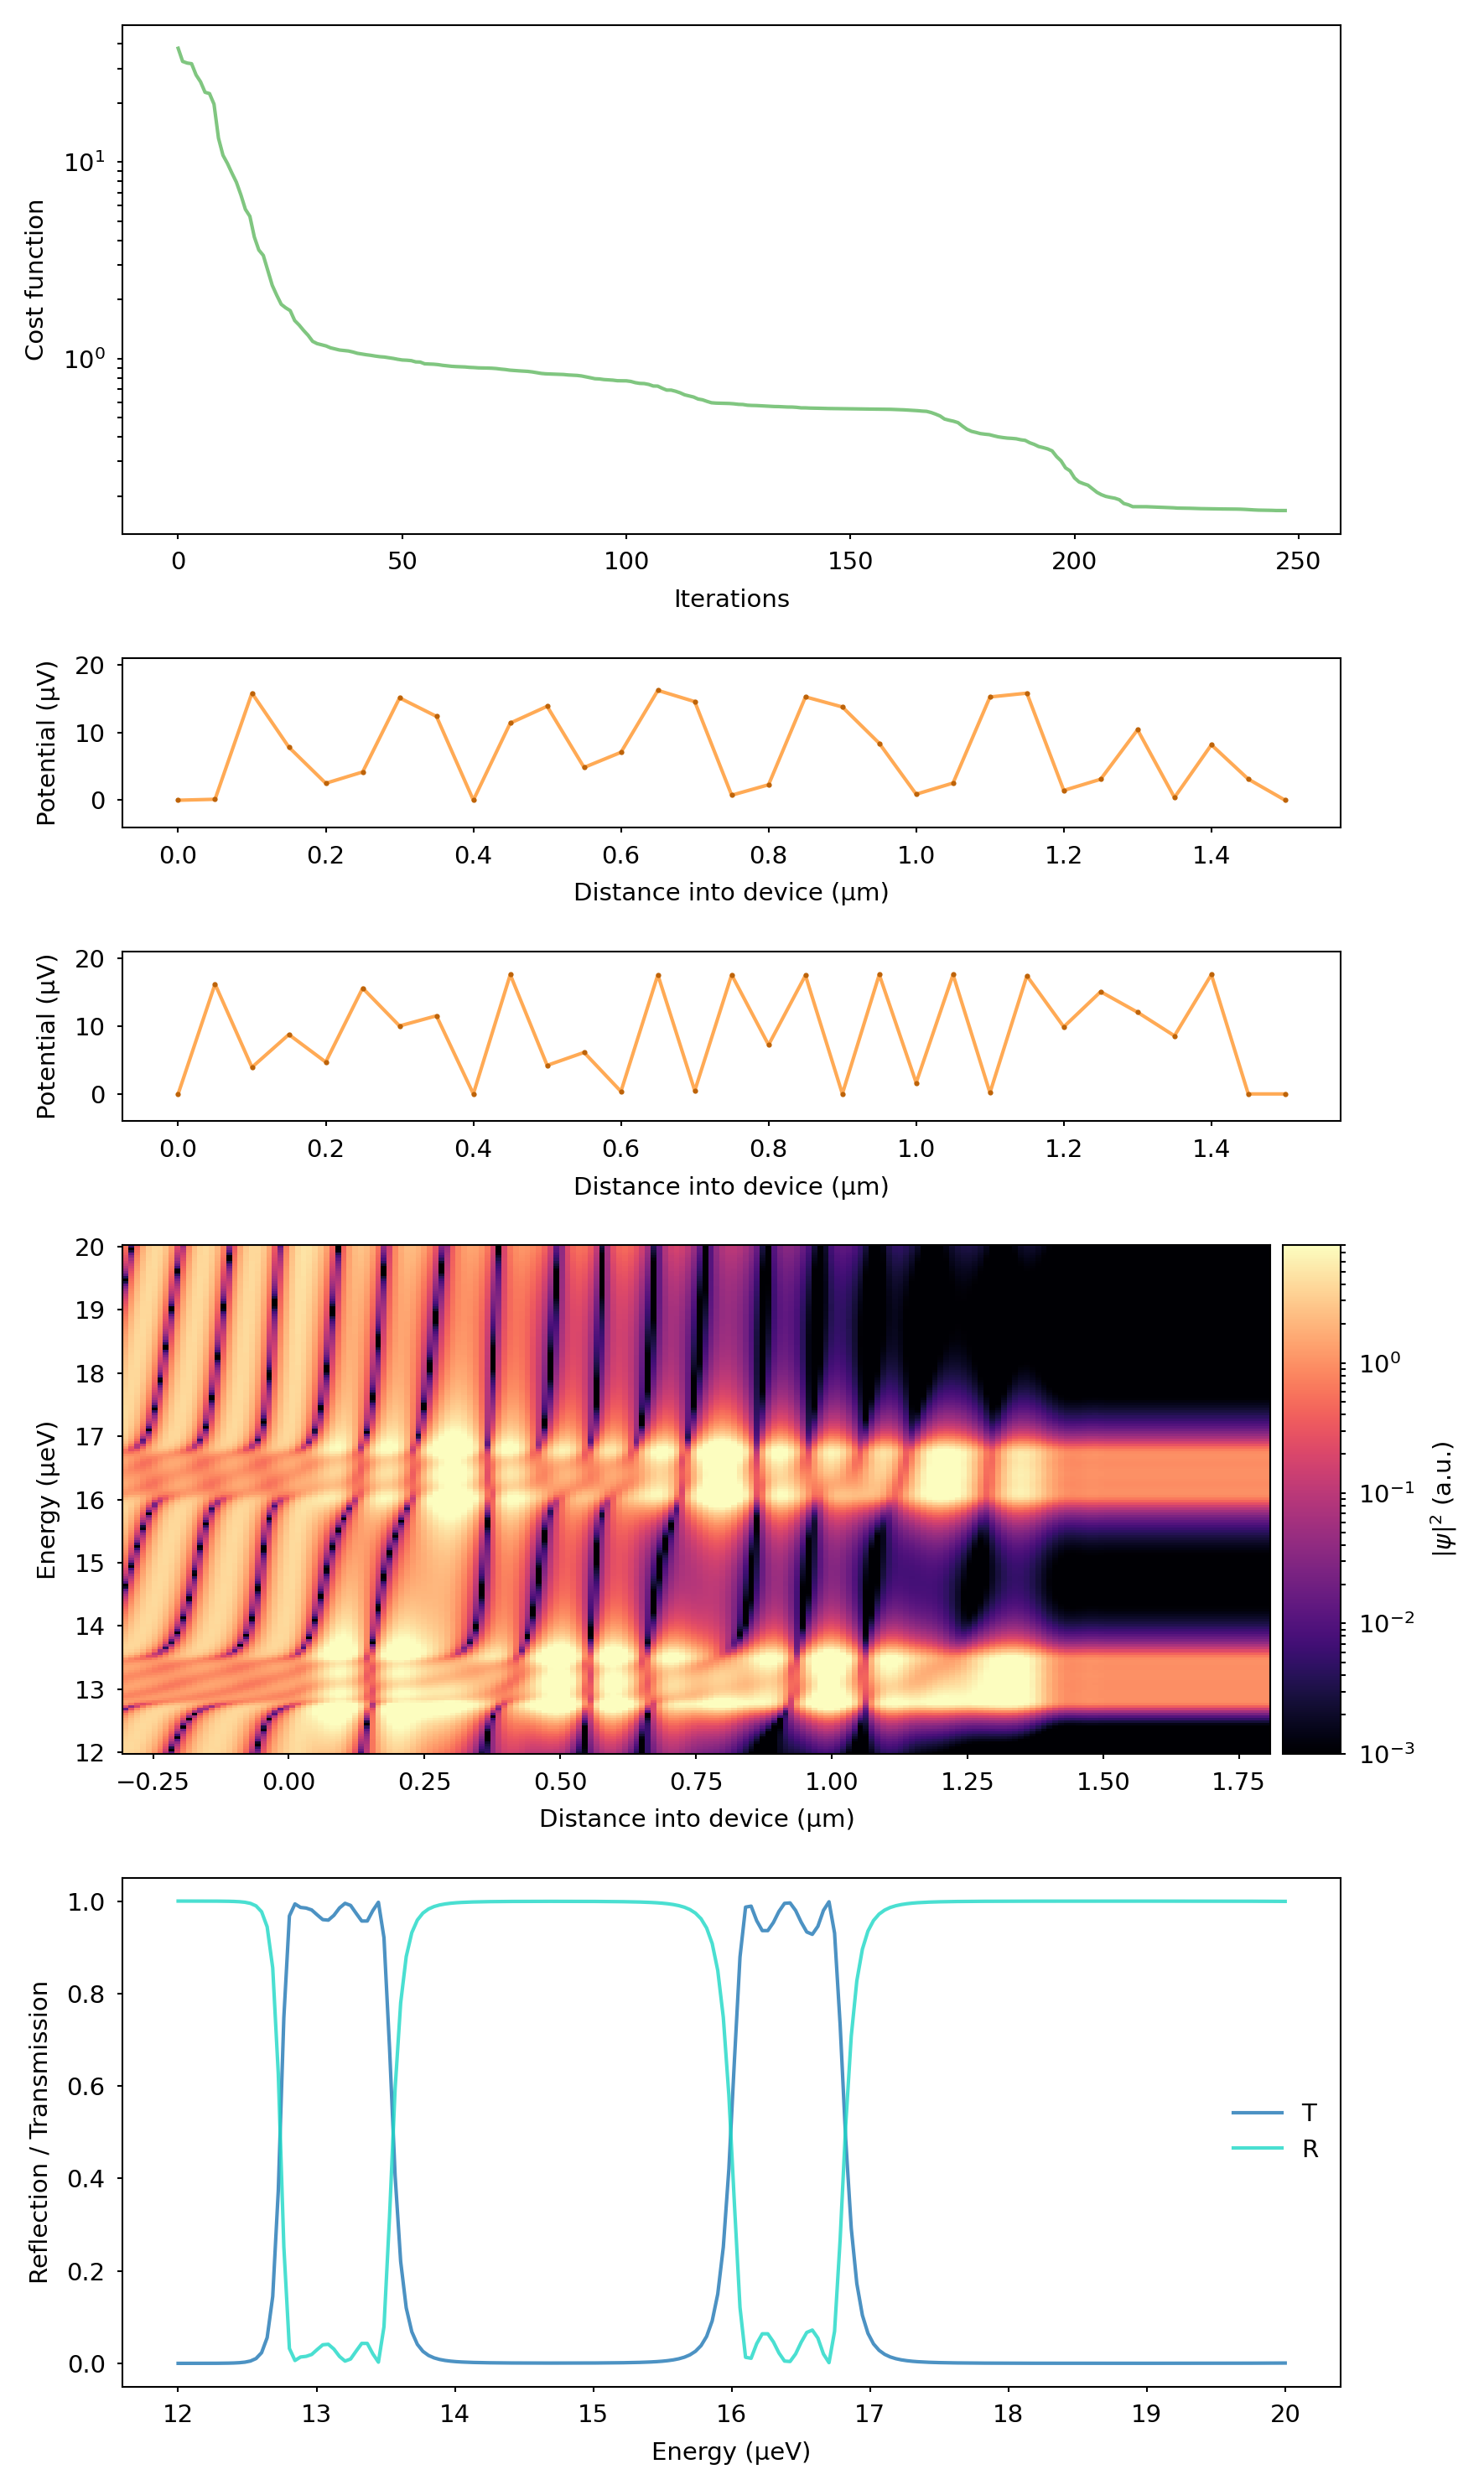

In [6]:
'''
#Pretend several days have passed, and we want to analyze Curly. We'll need to first load the old pickle the optimization generated. If you're doing analysis right after optimization, you DO NOT need to do the following 3 commands; they are only
#necessary if you're doing analysis on old data.
ad=agnostic_director()#Instantiate agnostic_director, which inherits all of agnostic_analysis's methods/attributes.
ad.set_physics(physics_package=quantum_tmm,mat1Call=materials_library.dummy_mat,mat2Call=materials_library.dummy_mat,param0Call=materials_library.zero_potential,paramNCall=materials_library.zero_potential)#Load physics
ad.load_evo(name='Curly',dir='/aDrive/afolder/') #Load Curly's pickle, which we stored in '/aDrive/afolder/' during optimization. Now, ad.evo is identical to the ad.evo from Curly's optimization, as if we had just now finished the optimization.
'''

#Starting here, the proceedure is the same whether you're using an imported evo or one from an optimization you just performed.
#I want to make sure I'm analyzing my data properly, so I want to know the settings I used during optimization, like the scale I used for my optParams/simPoints, the materials functions I used, etc. If you want to retrieve this info, call
ad.print_evo_info(sparse=True) #This prints the evo preamble and some other statistics to console. If sparse=True, less information will be provided. This function does nothing but prints ad.evo[-1] and some other stuff in a more readable format

#Initialize parameters analysis simulation. Most of these parameters are recycled from ad.set_structure and ad.run_optimization.
ad.init_analysis(simRange=[1.5,2.5], #The simulation range. Let's keep it as we optimized for.
                 simResolution=200, #The number of simulation points. We wanted to use as few points as we could get away with during optimization to minimize simulation time. That's not an issue for analysis, so let's crank it up for smoother plots.
                 simScale=es, #The simulation scale. I'm still working with my custom energy units
                 simType='fixedPoint', #Using 'fixedPoint' mode again. I can't think of any reason you would use a different mode for analysis than you did for optimization, but you could theoretically do it with some massaging of ad.evo.
                 third_variables=[{'mass':1}], #Let's keep the same third variable parameters. Again, these are for the air in the sub; the seawater model is different.
                 logSim=False, #Let's keep the simulation points linearly distributed
                 substrates=[{'material_call':materials_library.steel4340,'thickness':0.05}],superstrates=[], #We still need the sub's hull
                 num_layers=7) #The number of sublayers within each interval if simType=='fixedPoint'. Let's keep it at seven. If you give it nothing, it defaults to seven anyway.


#Initialize our multiplot. The arguments passed to this function are the "global" settings, which apply to the whole pyplot figure.
ad.init_plot(save_name='curlyTableau', #The name of the output plot, minus extension
             save_dir='/aDrive/adifferentfolder/', #Where to save the output plot.
             save=False, #Whether to save the output plot. Again, I'm assuming you do not have the above path on your computer, so let's not do that.
             show=True, #Whether to have pyplot display the output plot
             size=(6,10), #The size of the pyplot figure; first argument is width, second height
             dpi=300, #dpi of the output figure
             dark=False, #A quick way to apply a dark theme: white text, axes, etc. Could also change each color individually, but this is cumbersome
             savetype='.png', #Filetype of output plot. Supports any filetype that pyplot does.
             bbox_inches=None, #If this were a Bbox object, it would cause pyplot to save only the requested portion of the plot. We want all of it, so it's best not to touch this setting.
             tight_layout=True, #Apply tight layout. This should always be done unless pyplot is severely misbehaving
             subplots_adjust={'left':None,'right':None,'top':None,'bottom':None,'hspace':None,'wspace':None}, #Padding along the boarders of the figure and between subplots. See pyplot.subplots documentation. We're not going to touch it here.
             sharex=False, #Whether to have all your plots have the same x-axis. We don't want that
             height_ratios=[3,1,1,3,3]) #Relative height of each subplot. We want them all the same, except for the structure plots which can be 1/3 the height of the rest.

#We now add subplots in the order we wish them to appear. Let's put the cost function at the top. There are a ton of optional arguments. We're going to leave most of them as their defaults.
ad.add_subplotCostFunction(plot_grand_iters=False, #If True, displays a red dot at the start of each grand iteration.
                           lineColor='C2', #Color of the cost function. This could be any named color or a hex code. We're using C2, a dignified green worthy of Larry.
                           linestyle='-', #Style of the line. We're sticking with a solid line.
                           linewidth=1, #Width of the line. We're using 1 point.
                           axiswidth=0.5, #Width of the axis. Pyplot axes tend to be rather generously proportioned, so let's tune it down to 0.5 points.
                           tickwidth=0.5, #Width of the ticks. Usually the same as the axis width
                           ticklength=1.5, #Length of the ticks. Pyplot likes long ticks. I don't. Let's shorten them.
                           xlabel='Iterations', #The x-axis label.
                           ylabel='Cost function', #The y-axis label.
                           labelfontsize=7, #Size of the axis label font in points. Seven should do it.
                           tickfontsize=7, #Size of the tick label font in points. Seven should do it.
                           logy=True, #Whether to do a semilog plot on y. Let's do it to show off more of the cost function. Note that pyplot will cry if you try and do logscale on negative or zero values.
                           grand_iterations=[1,2], #Which grand iterations to plot. We had a two-element discretization map. This means ad.evo has keys -1,0,1,2,3. -1 is the preamble, nothing to plot. 0 is ONLY the initial condition. 3 is ONLY the final
                                                   #structure. We're only interested in what happened during optimziation, so let's just plot 1 and 2. If I left this blank, it would default to [0,1,2,3].
                           alpha=0.6) #Alpha value to apply to the color of the plot line. 0.6 makes C2 a pleasant algal green.


#Let's do the structure plots next. First, let's take a look at where we started: Our initial condition's potential distribution
ad.add_subplotStructure(grand_iteration=0, #The initial structure is stored in both the first entry of grand iteration 1, and the only entry in grand iteration 0. GI0 is the easier place to find it
                        iteration=0, #There is only one "iteration" in GI0, and it is the initial structure.
                        labelfontsize=7, #Let's keep the fonts consistent
                        tickfontsize=7,
                        noYticks=False, #We want y-ticks
                        color1='#ffaa55', #Let's make the interpolated potential outrageous orange
                        color2='#bd6309', #and the fixed-point potential color orangutang orange
                        yscale=8, #This number will scale the y-axis. It just so happens that 1 of our custom energy units is almost exactly 8μeV, so let's work in μV
                        xscale=50E-3, #This number will scale the x-axis. The custom distance units were strategically chosen so that 1 custom distance unit is exactly 50 nm. Let's work in μm though.
                        xlabel='Distance into device (μm)', #x-axis label
                        ylabel='Potential (μV)', #y-axis label
                        ylims=[-4,21], #Let's give the potential some breathing room.
                        noXticks=False, #We do want x-ticks
                        axiswidth=0.5,tickwidth=0.5,ticklength=1.5)

#That's all well and good, but we're really here for the invDes. Let's plot our final inverse designed structure.
ad.add_subplotStructure(grand_iteration=3, iteration=0, labelfontsize=7,tickfontsize=7,noYticks=False,color1='#ffaa55',color2='#bd6309',yscale=8,xscale=50E-3,xlabel='Distance into device (μm)', ylabel='Potential (μV)',ylims=[-4,21],noXticks=False,axiswidth=0.5,tickwidth=0.5,ticklength=1.5)

#Now we can admire Curly's grandure and laugh at the pathetic initial condition. But what's actually happening inside Curly? Let's plot the square magnitude of the wavefunction and find out
ad.add_subplotFields(grand_iteration=3,iteration=0, #We want the final structure
                     yscale=8,xscale=50E-3, #Let's keep the simulation scales in our plots.
                     resolution=200, #Let's sample the field at 200 points through the depth of the device
                     zlims=[1E-3,8], #We have some areas of the plot with very high realtive magnitude, and very low. Let's satruate the color scale for better contrast in the parts we care about
                     colorbarLabel='$|ψ|^2$ (a.u.)', #Label on the colorbar axis
                     xlabel='Distance into device (μm)', #Label on the x-axis
                     ylabel='Energy (μeV)', #Label on the y-axis
                     logy=False, #Don't log anything
                     labelfontsize=7,tickfontsize=7,axiswidth=0.5,tickwidth=0.5,ticklength=1.5, #Keep the same font/axis parameters
                     physicsPackageArg=None, #These arguments are passed to the interpolate method in the physics package, which knows how to handle them. Normally, this is which indicator to plot on z. Our physics package can only compute one kind of indicator, so we don't need to pass it anything.
                     leftPad=0.2,rightPad=0.2, #Like the structure plots, we want to see some of the incidence/transmisison medium. Let each be 20% the width of the device.
                     contourf=False, #Whether to use pyplot.contourf (if True) or pyplot.pcolormesh (if False)
                     colormap='magma', #Let's use the magma scheme because it looks cool.
                     colorbarNorm='log') #Let's use a log scale for the colorbar

#Last thing we want to see is the response of the device.
#Anything that could be classified as a response of a device is known as an "indicator". Each physics package has a .indicators() method with a list of valid indicator names. All the indicators we ask for are stored in ad.indicator_dict.
ad.get_indicatorsEvo(['TInst','RInst'],#Let's grab both the transmission and reflection spectra
                     3,0)#For the final structure

#To see these, we need to plot them.
#Before that, though, let's customize the lines which will represent our three devices. We're going to need to define these dictionaries to do that. Each dictionary should have the same keys as in ad.indicators_dict
datasetlabels={"TInst, {'mass': 1}, [3, 0]":'T',"RInst, {'mass': 1}, [3, 0]":'R'}#Let's give each set a shorter name in the legend
linewidths={"TInst, {'mass': 1}, [3, 0]":1,"RInst, {'mass': 1}, [3, 0]":1}#And give them the correct linewidths
lineColors={"TInst, {'mass': 1}, [3, 0]":'C0',"RInst, {'mass': 1}, [3, 0]":'#1dd8c6ff'}#And some swanky colors
linestyles={"TInst, {'mass': 1}, [3, 0]":'-',"RInst, {'mass': 1}, [3, 0]":'-'} #And make them all solid
alphas={"TInst, {'mass': 1}, [3, 0]":0.8,"RInst, {'mass': 1}, [3, 0]":0.8} #And add a bit of transparency

#Now we can generate the indicators subplot.
ad.add_subplotIndicators(ad.indicator_dict, #Use our indicator_dict
                         lineColors=lineColors,linestyles=linestyles,linewidths=linewidths,datasetLabels=datasetlabels,alphas=alphas, #Apply the customization dictionaries we just defined
                         labelfontsize=7,tickfontsize=7,legendfontsize=7,axiswidth=0.5,tickwidth=0.5,ticklength=1.5,
                         xlabel='Energy (μeV)',ylabel='Reflection / Transmission', #Set the axis labels
                         legend=True, #We've got two lines going on, so let's put a legend on this one
                         legendframe=False, #Let's ditch the legend frame
                         xscale=8) #Let's keep working in μeV

#Now all that's left to do is take a look.
ad.get_plot()

###Conclusion
---
And that's all there is to it! As a recap, to run an optimization with agnostic_director:


*   `ad=agnostic_director()` to instantiate
*   `ad.set_physics()` to load the physics package and material functions
*   `ad.set_optimizerFunctions()` to load the schedulers
*   `ad.set_structure()` to initialize the device
*   `ad.run_optimization()` to run the optimization

When this is done, everything you need to know about the final structure and the optimization process lives in `ad.evo`.

To load data from an old optimizaiton for analysis:

*   `ad=agnostic_director()` to instantiate
*   `ad.set_physics()` to load the physics package and material functions
*   `ad.load_evo()` to load the old `ad.evo` object.
*   `ad.print_evo_info()` to see what optimization parameters were used in the old optimization

To do some analyzing:

*   `ad.init_analysis()` to set up the analysis simulations
*   `ad.init_plot()` to initialize the multiplot
*   `ad.get_indicatorsEvo()` to compute the response of the final or intermediate structure
*   `ad.get_indicatorsCustom()` to compute the response of a custom structure
*   Add whatever subplots you want in the order you want them to appear
    *     `ad.add_subplotCostFunction()` to add a cost function subplot
    *     `ad.add_subplotStructure()` to add a structure subplot
    *     `ad.add_subplotFields()` to add a fields subplot
    *     `ad.add_subplotIndicators()` to add an indicators subplot
*   `ad.get_plot()` to show/save the multiplot

Hope this was helpful! There are a ton of options I didn't cover in this or the other two examples. Be sure to check the docs if you're curious.

